## Implementing r200b scaling
The following cells build utilities and computations to develop on the idea presented in the latest update of 25th May in the introduction.<br>
r200b will be found from M200b and the background density.

In [24]:
# This cell: Libraries imported
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from os import path

In [23]:
# This cell: Load and define all the general data to be used in the computations
colors=['g','b','r']
sourcePath="../SourceData/"  # Will not become a member of the git commits because CIC file is 1.1GB
fileNames=['b1','b1alpha','b1T10']
# Loading CIC data of density field. (512^3)
GridSize=512  # cubed of course.
cicSource="cic_snap049_grid512.dat"
data=np.reshape(np.fromfile(sourcePath+cicSource),(GridSize,GridSize,GridSize))

In [2]:
# This cell: Cosmology is defined. Simulation details are listed. Other constants to be used throughout are specified.
# Aseem's Cosmology
sigma_8=0.811
ns=0.961
h=0.7
Ob=0.045
Om=0.276

z=2.3         # Redshift specification
M_sun=1.989e+30  # M_sun in kg
Mega_parsec=3.086e+22  # parsec in metres
Delta=200.0   # Overdensity definition = Delta X background
rho_cr=((3*(100*h)**2)/(8*np.pi*6.673e-11))*((Mega_parsec/h**3)*1e+6/(M_sun/h))
# critical density of the Universe today 3H^2/8Pi*G in units M_sun.h^-1/(MPc.h^-1)^3
rho_m=Om*rho_cr # Units same as rho_cr. Don't need redshift considerations in comoving units i.e. Msun/h and MPc/h
del_crit=1.69
Lbox=150.0   # MPc/h

In [ ]:
# Loading the given Halo catalogues from original non-pickled files to get ID's and positions
b1=np.loadtxt(sourcePath+'b1.txt')
b1alpha=np.loadtxt(sourcePath+'b1alpha.txt')
b1T10=np.loadtxt(sourcePath+'b1T10.txt')

b1ID,b1alphaID,b1T10ID=np.array(b1[:,0],dtype=int),np.array(b1alpha[:,0],dtype=int),np.array(b1T10[:,0],dtype=int)
b1Pos,b1alphaPos,b1T10Pos=[],[],[]

b1Pos.append(b1[:,1])
b1Pos.append(b1[:,2])
b1Pos.append(b1[:,3])
b1Pos=np.array(b1Pos)
b1Pos=b1Pos.T  # Holds the positions of all the b1 halos in order according to b1T10

b1alphaPos.append(b1alpha[:,1])
b1alphaPos.append(b1alpha[:,2])
b1alphaPos.append(b1alpha[:,3])
b1alphaPos=np.array(b1alphaPos)
b1alphaPos=b1alphaPos.T

b1T10Pos.append(b1T10[:,1])
b1T10Pos.append(b1T10[:,2])
b1T10Pos.append(b1T10[:,3])
b1T10Pos=np.array(b1T10Pos)
b1T10Pos=b1T10Pos.T

In [29]:
# The Master Catalogue contains a large amount of information about all the Halos from the simulations
# This need not be loaded if the pickle dumps have already been created for the ID to R200b mapping
# An automated check is integrated in this cell

mapPath=sourcePath+"IDtoR200b_Map/"   # Path where the halo maps are stored
b1Map,b1alphaMap,b1T10Map=[],[],[]    # Lists will store the halo maps

#----------------------------------------------------------------------------------------------------

# Returns an array of r200b for each ID passed as an argument, in order
# Note that treesMap is sorted on IDs and hence, we can run a Binary Search on it

def findR200b(ID):
    low,high=0,treesMap[:,0].size-1
    while(low<=high):
        mid=int(low+(high-low)/2)
        if(ID==treesMap[mid,0]):
            return(treesMap[mid,1])
        elif(ID>treesMap[mid,0]):
            low=mid+1
        else:
            high=mid-1
    return(-1)

#----------------------------------------------------------------------------------------------------

# If the Halo maps are not already computed, find them and store them for future use. Runs only once
def findHaloMaps():
    masterCat=np.loadtxt(sourcePath+"out_49.trees")

    treesID=np.array(masterCat[:,1],dtype=int)  # ID of halos in the master catalogue
    treesR200b=np.cbrt((masterCat[:,36]*3)/(4*np.pi*rho_m*200))   # The r200b of each halo from the master catalogue.
    treesMap=np.column_stack((treesID,treesR200b))
    treesMap=treesMap[treesMap[:,0].argsort()]   # TreesMap is a 2 column array with R200b for given ID of the halo
    # TreesMap is sorted wrt the ID column so that Binary Search can be done on it too save shitloads of time.
    
    # Storing a Map of Halo ID to the R200b for that ID as Pickle dumps in "../SourceData/IDtoR200b_Map/"
    # Run only once i.e. the first time. From then onwards directly load pickle dumps.
    b1R200b,b1alphaR200b,b1T10R200b=[],[],[]
    for i in b1ID:
        b1R200b.append(findR200b(i))
    for j in b1alphaID:
        b1alphaR200b.append(findR200b(j))
    for k in b1T10ID:
        b1T10R200b.append(findR200b(k))

    b1Map=np.array([b1ID,b1R200b]).T
    b1alphaMap=np.array([b1alphaID,b1alphaR200b]).T
    b1T10Map=np.array([b1T10ID,b1T10R200b]).T
    pickle.dump(b1Map,open(mapPath+"b1Map.p",'wb'))
    pickle.dump(b1alphaMap,open(mapPath+"b1alphaMap.p",'wb'))
    pickle.dump(b1T10Map,open(mapPath+"b1T10Map.p",'wb'))

#----------------------------------------------------------------------------------------------------

# The automated check to save unnecessary data loading and computations

if(all([path.exists(mapPath+"b1Map.p"),path.exists(mapPath+"b1alphaMap.p"),path.exists(mapPath+"b1T10Map.p")])):
    b1Map=pickle.load(open(mapPath+"b1Map.p",'rb'))
    b1alphaMap=pickle.load(open(mapPath+"b1alphaMap.p",'rb'))
    b1T10Map=pickle.load(open(mapPath+"b1T10Map.p",'rb'))
else:
    findHaloMaps()

In [62]:
# To query R200b's faster from the given maps. Arguments: which catalogue to find in, ID of the halo
# Returns the R200b os the halo with given ID from the given catalogue
def queryR200b(cat,ID):
    opt=np.array(['b1','b1alpha','b1T10'])
    if not any(cat==opt):
        print('Please choose a correct catalogue. Catalogues available are: b1 | b1alpha | b1T10')
        return -1
    if cat=='b1':
        return float(b1Map[b1Map[:,0]==ID,1])
    if cat=='b1alpha':
        return float(b1alphaMap[b1alphaMap[:,0]==ID,1])
    if cat=='b1T10':
        return float(b1T10Map[b1T10Map[:,0]==ID,1])

In [7]:
# Helping functions for asymmetric STD calculations in averagedLOS()
# Asymmetry in statistics. Data is split into values above and below mean. A different standard deviation is found for each set.

# This function finds the STD given the mean value
def std_dev(a,mean):
    if len(a)==0:
        return 0
    else:
        return np.sqrt(np.sum((a-mean)**2)/a.size)

In [8]:
# customStats() returns DF in 2 modes, either binned or interpolated

def customStats(pos,DF,mode,rlim):
    allModes=np.array(['interp'])  # list of all available modes. Add to this list if developed further
    if not any(mode==allModes):
        print("Please enter a valid mode. Current available modes are - "+str(allModes))
        print("After entering a valid mode, run again.")
        return
    
    if mode=='interp':
        new_scale=np.linspace(0.0,rlim,rlim+1)
        new_scale=np.concatenate((-1.0*np.flip(new_scale[1:]),new_scale))
        new_DF=[]
        for p,d in zip(pos,DF):
            new_DF.append(np.interp(new_scale,p,d))
        result_DF=np.median(new_DF,axis=0)
        p16=np.percentile(new_DF,16,axis=0)
        p84=np.percentile(new_DF,84,axis=0)
        
        return new_scale,result_DF,p16,p84
    '''
    else:
        diff=[]
        for p in pos:
            diff.append(np.mean(p[1:]-p[:-1]))
        bin_width=np.percentile(diff,25)
        new_scale=np.arange(0.0,11.0,bin_width)
        new_scale=np.concatenate((-1.0*np.flip(new_scale[1:]),new_scale))
        new_boundary=np.concatenate(([-10.0],(new_scale[:-1]+new_scale[1:])/2.0,[10.0]))
        # This has 1 more element than new_scale and we will be finding all pos that lie between these
        
        result_DF=[]
        for p,d in zip(pos,DF):
            for i in range(0,len(new_boundary)-1):
                low,hi=new_boundary[i],new_boundary[i+1]
      '''          

In [66]:
# The LOS Method implemented has lines always passing parallel to x-axis and through the grid points
# Direction specifies which direction the LOS are parallel to
# r_lim specifies the limit to which LOS calculations should be done about the central position of the halo
# Limit is specified as distance in the real position coordinates
# Also presenting the linear density around the halo of interest

def simpleR200bLOS(halo,r200b,rlim,direction='x'):
    pos,df=np.array([]),np.array([])
    rlim=rlim*r200b  # the upper limit to which Density Field should be found
    
    grid2box=Lbox/(GridSize-1)   # MPc/CICcell
    box2grid=(GridSize-1)/Lbox   # CICcells/MPc
    
    # Connvert Halo co-odinates from real space to closest CIC Grid positions
    # Possible issue here. Experiment with floor, ceil and around
    #X=int(np.ceil(halo[0]*box2grid))
    #Y=int(np.ceil(halo[1]*box2grid))
    #Z=int(np.ceil(halo[2]*box2grid))
    
    #X=int(np.floor(halo[0]*box2grid))
    #Y=int(np.floor(halo[1]*box2grid))
    #Z=int(np.floor(halo[2]*box2grid))
    
    X=int(np.around(halo[0]*box2grid))
    Y=int(np.around(halo[1]*box2grid))
    Z=int(np.around(halo[2]*box2grid))
    
    # Initial values directly appended
    pos=np.append(pos,0.0)
    df=np.append(df,data[X,Y,Z])
    
    # Appending to front and back of the DF array iteratively, starting from center to make sure center is def included
    scale_grid=1
    scale=scale_grid*grid2box
    while scale<=rlim:   # runs till real scale is less than  rlim. NOt we started from -rlim.
        pos=np.append(pos,scale/r200b)
        pos=np.concatenate(([-scale/r200b],pos))
        
        pr,pl=[],[]
        if direction=='x':
            pr=np.array([X+scale_grid,Y,Z])
            pl=np.array([X-scale_grid,Y,Z])
        elif direction=='y':
            pr=np.array([X,Y+scale_grid,Z])
            pl=np.array([X,Y-scale_grid,Z])
        elif direction=='z':
            pr=np.array([X,Y,Z+scale_grid])   
            pl=np.array([X,Y,Z-scale_grid])   
        else:
            print("Please choose a valid direction for the LOS. Valid choices are - x | y | z")
            exit()
            
        pr[pr>=GridSize]=pr[pr>=GridSize]-GridSize
        pr[pr<0]=pr[pr<0]+GridSize   # periodicty of the box considered
        df=np.append(df,data[pr[0],pr[1],pr[2]])
        
        pl[pl>=GridSize]=pl[pl>=GridSize]-GridSize
        pl[pl<0]=pl[pl<0]+GridSize   # periodicty of the box considered
        
        df=np.concatenate(([data[pl[0],pl[1],pl[2]]],df))
        
        scale_grid+=1
        scale=scale_grid*grid2box
        
    return np.array(pos),np.array(df)

In [ ]:
po,denF=simpleR200bLOS(b1Pos[0],queryR200b('b1',b1ID[0]),20,'x'))

In [52]:
# LOS method implemented has lines passing through every halo of each catalogue to give a statistically robust estimate
# Arguments to be passed are halo IDs and corresponding positions, rlim_*R200b limit out to which compute DF...
# ...how many directions to consider for calculating the LOS - all | x | y | z
def averagedLOS_R200b(cat,rlim_,los_direction='all'):
    
    cat_opts=np.array(['b1','b1alpha','b1T10'])
    if not any(cat_opts==cat):
        print("Please enter a valid catalogue option, Valid arguments are: b1 | b1alpha | b1T10")
        return
    
    dir_opts=np.array(['all','x','y','z'])
    if not any(dir_opts == los_direction):
        print("Please enter a valid value to direction argument. Valid values -- all | x | y | z")
        return
    
    mocks,ID=[],[]
    if cat=='b1':
        mocks=b1Pos
        ID=b1ID
    if cat=='b1alpha':
        mocks=b1alphaPos
        ID=b1alphaID
    if cat=='b1T10':
        mocks=b1T10Pos
        ID=b1T10ID
    print('Secured Catalogue Data')
    print(mocks.shape,ID.shape)
    
    masterPos,masterDF=[],[]
    # masterDF will store LOS DF for each halo in mocks
    # resultDF will be the mean of masterDF at each scale
    
    if los_direction == 'all':
        for h in range(0,mocks[:,0].size):
            for directn in ['x','y','z']:
                scales,df=simpleR200bLOS(mocks[h],queryR200b(cat,ID[h]),rlim_,directn)
                masterDF.append(df)
                masterPos.append(scales)
        
    else:
        for h in range(0,mocks[:,0].size):
            scales,df=simpleR200bLOS(mocks[h],queryR200b(cat,ID[h]),rlim_,los_direction)
            masterDF.append(df)
            masterPos.append(scales)
    
    # ---------------------------------------------------------------------------------------------------------------
    # No 2 halos have the same R200b values, hence, all the DF values at R/R200b scales are found at different...
    #... non-matching scales. Due to this statistics can't be run on these points because we don't have DF values at...
    #... a single R/R200b.
    # 2 solutions to these are to either make bins or do an interpolation
    # Issue with bins is that the mean spacing of R/R200b between two neighboring points is too large and we can fit...
    #... only about 3-4 bins on one side of the Halo of interest.
    # Issue with interpolation is that the number of points to interpolate between is also very small, evidently,...
    #... the interpolation is not expected to be very robust
    
    # customStats() takes a go at both the methods by specifying in the mode which can take 2 values- 'bin','interp'
    # ---------------------------------------------------------------------------------------------------------------
    
   
    #resultDF,std_up,std_below=customStats(masterPos,masterDF,mode='std') # mode='std' | mode='percentile'
    masterPos,resultDF,prcntile16,prcntile84=customStats(masterPos,masterDF,'interp',rlim_)
    
    if len(masterPos)==len(resultDF):
        #return masterPos,resultDF,std_up,std_below
        return masterPos,resultDF,prcntile16,prcntile84
    else:
        print("Fatal error. Pos and DF sizes don't match.")
        return
    #return masterPos,masterDF

Secured Catalogue Data
(6808, 3) (6808,)
Secured Catalogue Data
(2024, 3) (2024,)
Secured Catalogue Data
(13937, 3) (13937,)
Computed averagedLOS_R200b in 30.421206951141357 seconds
Secured Catalogue Data
(6808, 3) (6808,)
Secured Catalogue Data
(2024, 3) (2024,)
Secured Catalogue Data
(13937, 3) (13937,)
Computed averagedLOS_R200b in 97.20973205566406 seconds
Secured Catalogue Data
(6808, 3) (6808,)
Secured Catalogue Data
(2024, 3) (2024,)
Secured Catalogue Data
(13937, 3) (13937,)
Computed averagedLOS_R200b in 224.24088144302368 seconds


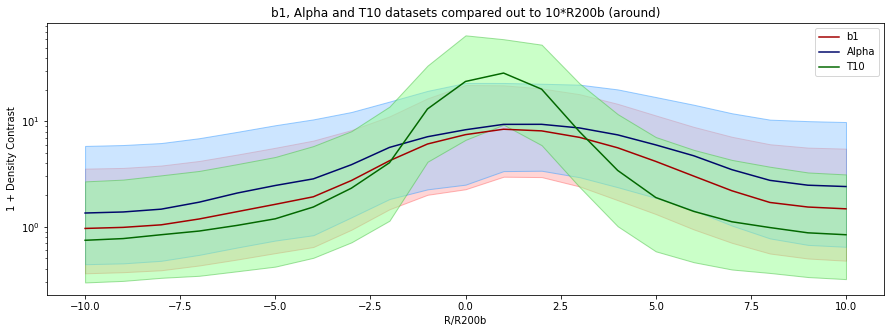

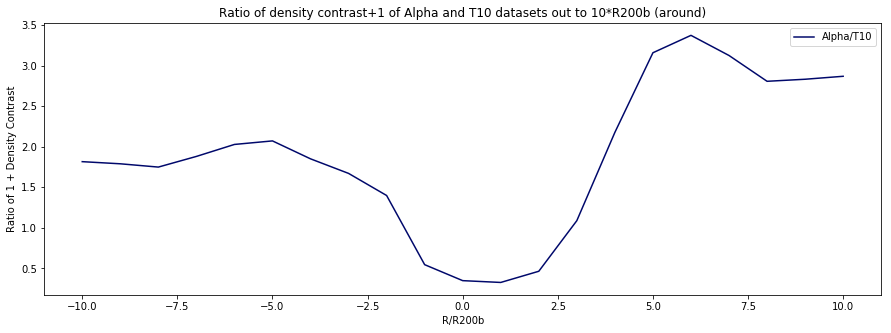

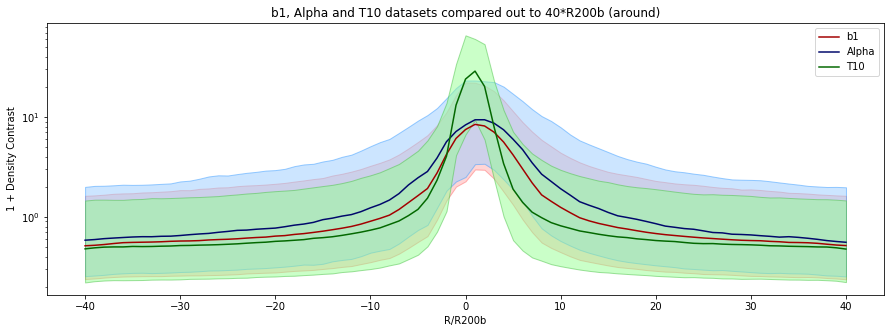

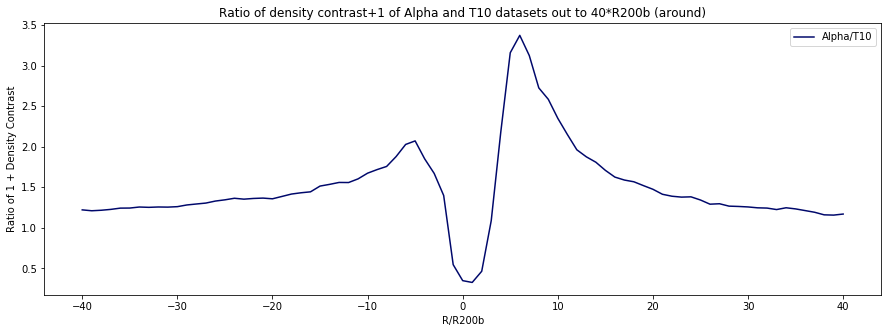

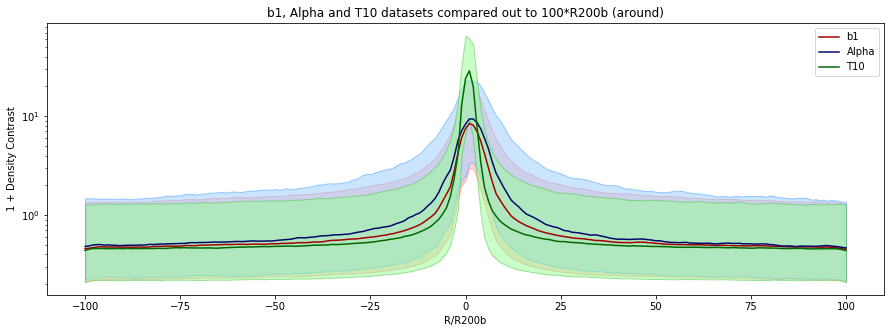

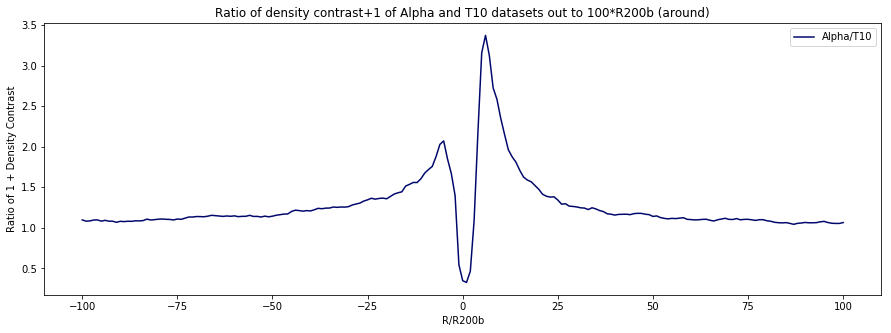

In [67]:
rl=[10,40,100]
fnum=0
for lim in rl:
    start=time.time()
    p_b1_r,df_b1_r,pt16_b1_r,pt84_b1_r=averagedLOS_R200b('b1',lim,'all')
    p_alpha_r,df_alpha_r,pt16_alpha_r,pt84_alpha_r=averagedLOS_R200b('b1alpha',lim,'all')
    p_t10_r,df_t10_r,pt16_t10_r,pt84_t10_r=averagedLOS_R200b('b1T10',lim,'all')
    end=time.time()
    print("Computed averagedLOS_R200b in "+str(end-start)+" seconds")
    
    # Plot all three datasets together
    plt.figure(num=fnum+1,figsize=(15,5))
    fnum+=1
    plt.title('b1, Alpha and T10 datasets compared out to '+str(lim)+'*R200b (around)')
    plt.plot(p_b1_r, df_b1_r+1.0, 'k', color='#A30000',label="b1")
    plt.fill_between(p_b1_r, pt84_b1_r+1.0, pt16_b1_r+1.0,alpha=0.5, edgecolor='#FF6B6B', facecolor='#FFADAD')
    plt.plot(p_alpha_r, df_alpha_r+1.0, 'k', color='#00086B',label="Alpha")
    plt.fill_between(p_alpha_r, pt84_alpha_r+1.0, pt16_alpha_r+1.0,alpha=0.5, edgecolor='#3a9cff', facecolor='#9bcdff')
    plt.plot(p_t10_r, df_t10_r+1.0, 'k', color='#036800',label="T10")
    plt.fill_between(p_t10_r, pt84_t10_r+1.0, pt16_t10_r+1.0,alpha=0.5, edgecolor='#49c145', facecolor='#96ff93')

    plt.yscale('log')
    plt.xlabel('R/R200b')
    plt.ylabel('1 + Density Contrast')
    plt.legend()
    plt.savefig('./Output/around/r200b'+str(lim)+'_around',bbox_inches='tight')

    # Plot the ratio between Alpha and T10
    plt.figure(num=fnum+1,figsize=(15,5))
    fnum+=1
    plt.title('Ratio of density contrast+1 of Alpha and T10 datasets out to '+str(lim)+'*R200b (around)')
    plt.plot(p_alpha_r, (df_alpha_r+1.0)/(df_t10_r+1.0), 'k', color='#00086B',label="Alpha/T10")
    #plt.yscale('log')
    plt.xlabel('R/R200b')
    plt.ylabel('Ratio of 1 + Density Contrast')
    plt.legend()
    plt.savefig('./Output/around/r200b'+str(lim)+'_RatioAlphT10_around',bbox_inches='tight')

In [ ]:
# This cell is specifically made to run the averagedLOSv2() function because of more complex plotting details.

fig,ax=plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(13,18),dpi=200)
fig.text(0.5, 0.0, 'Distance from Halo Center (R/R200b)', ha='center',fontsize=20)
fig.text(0.0, 0.5, '1+Density Contrast', va='center', rotation='vertical',fontsize=20)

plt.subplot(3,1,1)
plt.plot(p_b1_r, df_b1_r+1.0, 'k', color='#A30000',label="b1")
plt.fill_between(p_b1_r, pt84_b1_r+1.0, pt16_b1_r+1.0,alpha=0.5, edgecolor='#FF6B6B', facecolor='#FFADAD')
plt.ylim([0.1,3e1])
plt.yscale('log')
plt.legend()

plt.subplot(3,1,2)
plt.plot(p_alpha_r, df_alpha_r+1.0, 'k', color='#00086B',label="Alpha")
plt.fill_between(p_alpha_r, pt84_alpha_r+1.0, pt16_alpha_r+1.0,alpha=0.5, edgecolor='#3a9cff', facecolor='#9bcdff')
plt.ylim([0.1,3e1])
plt.yscale('log')
plt.legend()

plt.subplot(3,1,3)
plt.plot(p_t10_r, df_t10_r+1.0, 'k', color='#036800',label="T10")
plt.fill_between(p_t10_r, pt84_t10_r+1.0, pt16_t10_r+1.0,alpha=0.5, edgecolor='#49c145', facecolor='#96ff93')
plt.ylim([0.1,3e1])
plt.yscale('log')
plt.legend()